## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from IPython.display import display

import matplotlib.pyplot as plt
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

print("Packages Imported!")

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Packages Imported!


## Settings

In [5]:
# MANIFEST_PATH = "E:/datasets/allen_vc/manifest_files/manifest.json"
MANIFEST_PATH = "D:/datasets/allen_vc/manifest.json"
PROJECT_PATH = "G:/Shared drives/visual_encoding"
# REPO_PATH = 'C:/Users/User/visual_encoding'
REPO_PATH = 'C:/Users/micha/projects/visual_encoding'

## Functions

In [3]:
def optotagging_spike_counts(session, bin_edges, trials, units):
    
    time_resolution = np.mean(np.diff(bin_edges))
    
    # Empty matrix for storing data
    spike_matrix = np.zeros( (len(trials), len(bin_edges), len(units)) )

    for unit_idx, unit_id in enumerate(units.index.values):

        spike_times = session.spike_times[unit_id]

        for trial_idx, trial_start in enumerate(trials.start_time.values):
            
            # Mask for sectioning spike times based on bin
            in_range = (spike_times > (trial_start + bin_edges[0])) * \
                       (spike_times < (trial_start + bin_edges[-1]))

            # Create 0/1 spiketrain for correct unit and trial
            binned_times = ((spike_times[in_range] - (trial_start + bin_edges[0])) / time_resolution).astype('int')
            spike_matrix[trial_idx, binned_times, unit_idx] = 1

    return xr.DataArray(
        name='spike_counts',
        data=spike_matrix,
        coords={
            'trial_id': trials.index.values,
            'time_relative_to_stimulus_onset': bin_edges,
            'unit_id': units.index.values
        },
        dims=['trial_id', 'time_relative_to_stimulus_onset', 'unit_id']
    )


def plot_optotagging_response(da):

    plt.figure(figsize=(5,10))

    # Take mean across all trials, plot as image
    plt.imshow(da.mean(dim='trial_id').T / time_resolution, 
               extent=[np.min(bin_edges), np.max(bin_edges),
                       0, len(units)],
               aspect='auto', vmin=0, vmax=200)    

    # Plot stimulus start/end lines
    for bound in [0.0005, 0.0095]:
        plt.plot([bound, bound],[0, len(units)], ':', color='white', linewidth=1.0)

    plt.xlabel('Time (s)')
    plt.ylabel('Unit #')

    cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb.set_label('Mean firing rate (Hz)')

## Load Dataset

In [6]:
# Create Allensdk cache object
cache = EcephysProjectCache.from_warehouse(manifest=MANIFEST_PATH)

In [7]:
# Isolate functional connectivity sections
sessions = cache.get_session_table()
functional_connectivity_sessions = sessions[sessions['session_type'] == 'functional_connectivity']

# Observe Cre distribution
functional_connectivity_sessions['full_genotype'].value_counts()

wt/wt                                              14
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       6
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       3
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     3
Name: full_genotype, dtype: int64

In [8]:
functional_connectivity_sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
766640955,2019-10-03T00:00:00Z,744912849,functional_connectivity,133.0,M,wt/wt,842,2233,6,"[MB, APN, NOT, DG, CA1, VISam, nan, PF, TH, LP..."
767871931,2019-10-03T00:00:00Z,753795610,functional_connectivity,135.0,M,wt/wt,713,2231,6,"[MRN, APN, MB, DG, CA1, VISrl, nan, VISam, PO,..."
768515987,2019-10-03T00:00:00Z,754477358,functional_connectivity,136.0,M,wt/wt,802,2217,6,"[MB, APN, NOT, DG, CA1, VISam, nan, Eth, LP, P..."
771160300,2019-10-03T00:00:00Z,754488979,functional_connectivity,142.0,M,wt/wt,930,2230,6,"[SCig, PPT, NOT, SUB, ProS, CA1, VISam, nan, A..."
771990200,2019-10-03T00:00:00Z,756578435,functional_connectivity,108.0,M,wt/wt,546,2229,6,"[APN, MB, DG, CA1, VISam, nan, PO, LP, VISpm, ..."


In [9]:
# Light delivery switched from LED (False) to Laser (True) halfway through
functional_connectivity_sessions.index.values >= 789848216

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

## Example Session

In [10]:
session = cache.get_session_data(786091066)
session.full_genotype

'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'

In [11]:
help(session)

Help on EcephysSession in module allensdk.brain_observatory.ecephys.ecephys_session object:

class EcephysSession(allensdk.core.lazy_property.lazy_property_mixin.LazyPropertyMixin)
 |  EcephysSession(api: allensdk.brain_observatory.ecephys.ecephys_session_api.ecephys_session_api.EcephysSessionApi, test: bool = False, **kwargs)
 |  
 |  Represents data from a single EcephysSession
 |  
 |  Attributes
 |  ----------
 |  units : pd.Dataframe
 |      A table whose rows are sorted units (putative neurons) and whose
 |      columns are characteristics of those units.
 |      Index is:
 |          unit_id : int
 |              Unique integer identifier for this unit.
 |      Columns are:
 |          firing_rate : float
 |              This unit's firing rate (spikes / s) calculated over the
 |              window of that unit's activity (the time from its first
 |              detected spike to its last).
 |          isi_violations : float
 |              Estamate of this unit's contamination

In [12]:
session.units.head()

,waveform_repolarization_slope,presence_ratio,L_ratio,waveform_velocity_above,amplitude_cutoff,waveform_duration,firing_rate,nn_miss_rate,cluster_id,local_index_unit,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
950992037,0.827148,0.99,1.578580e-07,0.000000,0.000117,0.288442,13.173560,0.000000,0,0,...,10.0,SCig,8429.0,2697.0,6742.0,probeA,See electrode locations,29999.965512,1249.998563,True
950992053,0.510683,0.99,9.216128e-08,NaN,0.000917,0.219765,10.146275,0.000000,2,2,...,10.0,SCig,8408.0,2656.0,6763.0,probeA,See electrode locations,29999.965512,1249.998563,True
950992177,0.393553,0.99,1.054813e-03,0.686767,0.073858,1.098827,7.911522,0.000666,19,19,...,382.0,CA1,8026.0,1726.0,7340.0,probeA,See electrode locations,29999.965512,1249.998563,True
950992173,0.933805,0.99,4.239420e-06,0.755444,0.000407,0.824121,4.363801,0.000049,18,18,...,382.0,CA1,8026.0,1726.0,7340.0,probeA,See electrode locations,29999.965512,1249.998563,True
950992188,0.320981,0.99,7.454824e-04,1.442211,0.063526,1.194975,0.979358,0.000101,21,21,...,382.0,CA1,8020.0,1705.0,7355.0,probeA,See electrode locations,29999.965512,1249.998563,True


In [13]:
session.optogenetic_stimulation_epochs

,start_time,condition,level,stop_time,stimulus_name,duration
id,,,,,,
0,9215.34368,a single square pulse,1.0,9215.34868,pulse,0.005
1,9217.31384,a single square pulse,2.5,9217.32384,pulse,0.010
2,9219.35388,2.5 ms pulses at 10 Hz,4.0,9220.35388,fast_pulses,1.000
3,9221.34398,half-period of a cosine wave,2.5,9222.34398,raised_cosine,1.000
4,9223.23404,half-period of a cosine wave,2.5,9224.23404,raised_cosine,1.000
...,...,...,...,...,...,...
175,9554.72852,2.5 ms pulses at 10 Hz,1.0,9555.72852,fast_pulses,1.000
176,9556.56869,a single square pulse,2.5,9556.57369,pulse,0.005
177,9558.30871,a single square pulse,4.0,9558.31371,pulse,0.005


In [14]:
columns = ['stimulus_name', 'duration','level']

# All unique stimuli
session.optogenetic_stimulation_epochs.drop_duplicates(columns).sort_values(by=columns).drop(columns=['start_time','stop_time'])

,condition,level,stimulus_name,duration
id,,,,
9,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
5,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
2,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
0,a single square pulse,1.0,pulse,0.005
7,a single square pulse,2.5,pulse,0.005
16,a single square pulse,4.0,pulse,0.005
8,a single square pulse,1.0,pulse,0.010
1,a single square pulse,2.5,pulse,0.010
12,a single square pulse,4.0,pulse,0.010


In [15]:
"""
we've found that the 10 ms pulses are the most useful stimulus for finding true light-evoked activity. 
These pulses provide a long enough artifact-free window to observe light-evoked spikes, 
but do not last long enough to be contaminated by visually driven activity.
"""

# Select all stimulation trials for a duration
trials = session.optogenetic_stimulation_epochs[(session.optogenetic_stimulation_epochs.duration > 0.009) & \
                                                (session.optogenetic_stimulation_epochs.duration < 0.02)]
# Select units of interest
units = session.units[session.units['ecephys_structure_acronym'] == 'VISp']

# Set bin surrounding stimulus params
time_resolution = 0.0005 # 0.5 ms bins
bin_edges = np.arange(-0.01, 0.025, time_resolution)

da = optotagging_spike_counts(session, bin_edges, trials, units)

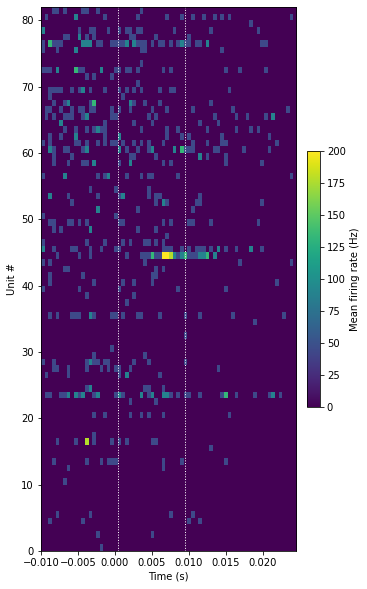

In [16]:
plot_optotagging_response(da)

In [17]:
# Sum spikes across time slice, take mean over trials --> mean firing rate
baseline = da.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002))
baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))
evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

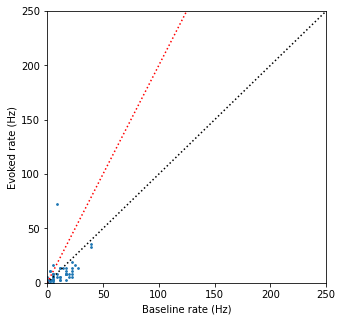

In [18]:
plt.figure(figsize=(5,5))

plt.scatter(baseline_rate, evoked_rate, s=3)

axis_limit = 250
plt.plot([0,axis_limit],[0,axis_limit], ':k')
plt.plot([0,axis_limit],[0,axis_limit*2], ':r')
plt.xlim([0,axis_limit])
plt.ylim([0,axis_limit])

plt.xlabel('Baseline rate (Hz)')
_ = plt.ylabel('Evoked rate (Hz)')

In [19]:
cre_pos_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) > 2].values # add 1 to prevent divide-by-zero errors
cre_pos_units

array([951001485, 951001777, 951002222, 951002348, 951002333, 951002295,
       951002529, 951003999, 951002943], dtype=int64)

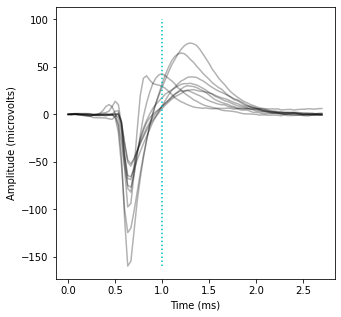

In [20]:
plt.figure(figsize=(5,5))

for unit_id in cre_pos_units:
    
    # Locate peak channel for unit, extract waveform data, plot
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)
    
    plt.plot(wv.time * 1000, wv, 'k', alpha=0.3)

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
_ =plt.plot([1.0, 1.0],[-160, 100],':c')

## Compute Cell Type Features

In [21]:
# Goals:

# - Find number and proportion of responsive units to opto stimuli (and by how much)
# - Based on waveform characteristics of Excitatory v Inhibitory, classify each unit
# - Final unit dataframe for each session with relevant features

In [22]:
# Get relevant units, keep waveform stats, compute optogenetic response (all 10 ms pulses for now)

In [23]:
# Define function to compute baseline and evoked rate for all units in a session, across all trials, for a particular stim

def calc_optotagging_response(session, stimulus_params, region, raster_plot=False, scatter_plot=False):
    
    duration = stimulus_params.get('duration') # Must be provided
    level = stimulus_params.get('level', None)
    name = stimulus_params.get('stimulus_name', None)
    
    # Select trials
    trials = session.optogenetic_stimulation_epochs[(session.optogenetic_stimulation_epochs.duration > duration - 0.001) & \
                                                    (session.optogenetic_stimulation_epochs.duration < duration + 0.001)]
    if level is not None:
        level_val = sorted(trials['level'].unique())[level-1]
        trials = trials[(trials['level'] == level_val)]
    if name is not None:
        trials = trials[(trials['stimulus_name'] == name)]
        
    if len(trials) == 0:
        return _, _, _, False
    
    # Select units of interest
    units = session.units[session.units['ecephys_structure_acronym'] == region]

    # Set bin surrounding stimulus params
    time_resolution = 0.0005 # 0.5 ms bins
    bin_edges = np.arange(-duration, duration*2.5, time_resolution) # observe 1*duration before stim and 2.5*duration after

    da = optotagging_spike_counts(session, bin_edges, trials, units)
    
    if raster_plot:
        plot_optotagging_response(da)
    
    # Section data based on time relative to stimulus onset and compute firing rates
    baseline = da.sel(time_relative_to_stimulus_onset=slice(-duration,-0.002))
    baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset') / (duration-0.002)
    
    evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001, duration - 0.001))
    evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset') / (duration-0.002)
    
    if scatter_plot:
        
        plt.figure(figsize=(5,5))

        plt.scatter(baseline_rate.mean(dim='trial_id'), evoked_rate.mean(dim='trial_id'), s=3)

        axis_limit = 250
        plt.plot([0,axis_limit],[0,axis_limit], ':k')
        plt.plot([0,axis_limit],[0,axis_limit*2], ':r') # 2*baseline response
        plt.xlim([0,axis_limit])
        plt.ylim([0,axis_limit])

        plt.xlabel('Baseline rate (Hz)')
        _ = plt.ylabel('Evoked rate (Hz)')
        
    return da.unit_id, baseline_rate, evoked_rate, True

Positive Units: [951001485 951001777 951002222 951002348 951002333 951002295 951002529
 951003999 951002943]


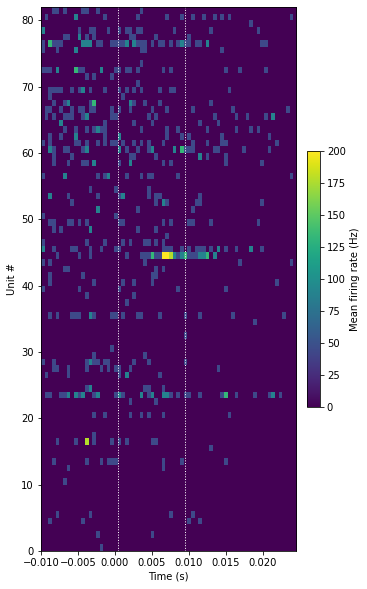

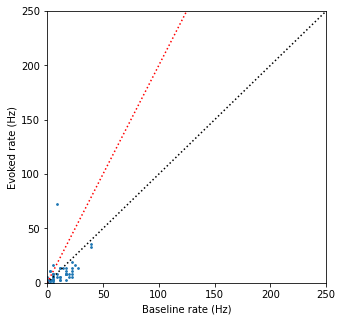

In [24]:
# Example
stimulus_params = {'duration': 0.01}
units, baseline_rate, evoked_rate, _ = calc_optotagging_response(session, stimulus_params, 'VISp', raster_plot=True, scatter_plot=True)
print(f"Positive Units: {units[(evoked_rate.mean(dim='trial_id') / (baseline_rate.mean(dim='trial_id') + 1)) > 2].values}") # +1 zerodivisionerror can be better

Let's calculate these metrics for multiple stimuli across all sessions.

In [38]:
# define utility function for computing baseline and evoked rates into a DataFrame

def create_unit_opto_df(region, stimulus_params, fname_out=None):
    
    unit_dfs = []
    
    for session_id in functional_connectivity_sessions.index:
        print(f'Computing Session: \t {session_id}')

        session = cache.get_session_data(session_id)

        _, baseline_rate, evoked_rate, has_trials = calc_optotagging_response(session, stimulus_params, region, raster_plot=False, scatter_plot=False)
        
        if not has_trials:
            print(f'\t\tNo trials found for this stimulus!')
            continue

        units = session.units[session.units['ecephys_structure_acronym'] == region][['ecephys_structure_acronym']].reset_index()

        units['genotype'] = session.full_genotype
        units['trial_id'] = [range(baseline_rate.shape[0])]*units.shape[0]
        units['opto_baseline_rate'], units['opto_evoked_rate'] = [list(x) for x in np.swapaxes(baseline_rate.values,0,1)], [list(x) for x in np.swapaxes(evoked_rate.values,0,1)]

        unit_dfs.append(units)
        
    all_units_df = pd.concat(unit_dfs).explode(['opto_baseline_rate', 'opto_evoked_rate', 'trial_id']).reset_index(drop=True)
        
    if fname_out is not None:
        all_units_df.to_csv(fname_out, index=False)
        
    return create_unit_opto_df


In [26]:
columns = ['stimulus_name', 'duration','level']

for session_id in functional_connectivity_sessions.index:

    session = cache.get_session_data(session_id)

    # All unique stimuli
    unique_stim = session.optogenetic_stimulation_epochs.drop_duplicates(columns).sort_values(by=columns).drop(columns=['start_time','stop_time'])
    
    # display(unique_stim)
    
    print(f'Session: {session_id}, Names: {unique_stim[columns[0]].unique()}, Durations: {unique_stim[columns[1]].unique()}, Levels: {unique_stim[columns[2]].unique()}')

,condition,level,stimulus_name,duration
id,,,,
11,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
0,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
1,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
9,a single square pulse,1.0,pulse,0.005
16,a single square pulse,2.5,pulse,0.005
21,a single square pulse,4.0,pulse,0.005
2,a single square pulse,1.0,pulse,0.010
8,a single square pulse,2.5,pulse,0.010
5,a single square pulse,4.0,pulse,0.010


Session: 766640955, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]


,condition,level,stimulus_name,duration
id,,,,
3,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
35,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
6,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
8,a single square pulse,1.0,pulse,0.005
1,a single square pulse,2.5,pulse,0.005
4,a single square pulse,4.0,pulse,0.005
0,a single square pulse,1.0,pulse,0.010
15,a single square pulse,2.5,pulse,0.010
2,a single square pulse,4.0,pulse,0.010


Session: 767871931, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]


,condition,level,stimulus_name,duration
id,,,,
1,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
12,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
5,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
2,a single square pulse,1.0,pulse,0.005
14,a single square pulse,2.5,pulse,0.005
0,a single square pulse,4.0,pulse,0.005
7,a single square pulse,1.0,pulse,0.010
19,a single square pulse,2.5,pulse,0.010
11,a single square pulse,4.0,pulse,0.010


Session: 768515987, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]


,condition,level,stimulus_name,duration
id,,,,
3,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
6,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
5,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
25,a single square pulse,1.0,pulse,0.005
1,a single square pulse,2.5,pulse,0.005
8,a single square pulse,4.0,pulse,0.005
4,a single square pulse,1.0,pulse,0.010
11,a single square pulse,2.5,pulse,0.010
10,a single square pulse,4.0,pulse,0.010


Session: 771160300, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]


,condition,level,stimulus_name,duration
id,,,,
1,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
5,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
0,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
11,a single square pulse,1.0,pulse,0.005
3,a single square pulse,2.5,pulse,0.005
19,a single square pulse,4.0,pulse,0.005
20,a single square pulse,1.0,pulse,0.010
2,a single square pulse,2.5,pulse,0.010
4,a single square pulse,4.0,pulse,0.010


Session: 771990200, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]


,condition,level,stimulus_name,duration
id,,,,
8,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
6,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
12,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
4,a single square pulse,1.0,pulse,0.005
1,a single square pulse,2.5,pulse,0.005
0,a single square pulse,4.0,pulse,0.005
5,a single square pulse,1.0,pulse,0.010
3,a single square pulse,2.5,pulse,0.010
22,a single square pulse,4.0,pulse,0.010


Session: 774875821, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]


,condition,level,stimulus_name,duration
id,,,,
15,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
1,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
20,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
6,a single square pulse,1.0,pulse,0.005
3,a single square pulse,2.5,pulse,0.005
9,a single square pulse,4.0,pulse,0.005
18,a single square pulse,1.0,pulse,0.010
33,a single square pulse,2.5,pulse,0.010
22,a single square pulse,4.0,pulse,0.010


Session: 778240327, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]


,condition,level,stimulus_name,duration
id,,,,
22,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
16,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
1,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
9,a single square pulse,1.0,pulse,0.005
7,a single square pulse,2.5,pulse,0.005
2,a single square pulse,4.0,pulse,0.005
17,a single square pulse,1.0,pulse,0.010
11,a single square pulse,2.5,pulse,0.010
5,a single square pulse,4.0,pulse,0.010


Session: 778998620, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]


,condition,level,stimulus_name,duration
id,,,,
16,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
7,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
1,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
38,a single square pulse,1.0,pulse,0.005
5,a single square pulse,2.5,pulse,0.005
3,a single square pulse,4.0,pulse,0.005
12,a single square pulse,1.0,pulse,0.010
10,a single square pulse,2.5,pulse,0.010
0,a single square pulse,4.0,pulse,0.010


Session: 779839471, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]


,condition,level,stimulus_name,duration
id,,,,
5,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
6,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
2,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
7,a single square pulse,1.0,pulse,0.005
11,a single square pulse,2.5,pulse,0.005
56,a single square pulse,4.0,pulse,0.005
3,a single square pulse,1.0,pulse,0.010
8,a single square pulse,2.5,pulse,0.010
4,a single square pulse,4.0,pulse,0.010


Session: 781842082, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]


,condition,level,stimulus_name,duration
id,,,,
9,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
5,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
2,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
0,a single square pulse,1.0,pulse,0.005
7,a single square pulse,2.5,pulse,0.005
16,a single square pulse,4.0,pulse,0.005
8,a single square pulse,1.0,pulse,0.010
1,a single square pulse,2.5,pulse,0.010
12,a single square pulse,4.0,pulse,0.010


Session: 786091066, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]


,condition,level,stimulus_name,duration
id,,,,
4,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
9,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
2,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
20,a single square pulse,1.0,pulse,0.005
5,a single square pulse,2.5,pulse,0.005
35,a single square pulse,4.0,pulse,0.005
0,a single square pulse,1.0,pulse,0.010
1,a single square pulse,2.5,pulse,0.010
3,a single square pulse,4.0,pulse,0.010


Session: 787025148, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]


,condition,level,stimulus_name,duration
id,,,,
1,2.5 ms pulses at 10 Hz,1.3,fast_pulses,1.000
0,2.5 ms pulses at 10 Hz,1.7,fast_pulses,1.000
11,2.5 ms pulses at 10 Hz,2.0,fast_pulses,1.000
4,a single square pulse,1.3,pulse,0.005
13,a single square pulse,1.7,pulse,0.005
10,a single square pulse,2.0,pulse,0.005
33,a single square pulse,1.3,pulse,0.010
5,a single square pulse,1.7,pulse,0.010
7,a single square pulse,2.0,pulse,0.010


Session: 789848216, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.3 1.7 2. ]


,condition,level,stimulus_name,duration
id,,,,
4,2.5 ms pulses at 10 Hz,1.3,fast_pulses,1.000
22,2.5 ms pulses at 10 Hz,1.7,fast_pulses,1.000
0,2.5 ms pulses at 10 Hz,2.0,fast_pulses,1.000
5,a single square pulse,1.3,pulse,0.005
15,a single square pulse,1.7,pulse,0.005
2,a single square pulse,2.0,pulse,0.005
32,a single square pulse,1.3,pulse,0.010
14,a single square pulse,1.7,pulse,0.010
12,a single square pulse,2.0,pulse,0.010


Session: 793224716, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.3 1.7 2. ]


,condition,level,stimulus_name,duration
id,,,,
12,2.5 ms pulses at 10 Hz,1.3,fast_pulses,1.000
17,2.5 ms pulses at 10 Hz,1.7,fast_pulses,1.000
46,2.5 ms pulses at 10 Hz,2.0,fast_pulses,1.000
1,a single square pulse,1.3,pulse,0.005
8,a single square pulse,1.7,pulse,0.005
7,a single square pulse,2.0,pulse,0.005
34,a single square pulse,1.3,pulse,0.010
2,a single square pulse,1.7,pulse,0.010
20,a single square pulse,2.0,pulse,0.010


Session: 794812542, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.3 1.7 2. ]


,condition,level,stimulus_name,duration
id,,,,
1,2.5 ms pulses at 10 Hz,1.3,fast_pulses,1.000
25,2.5 ms pulses at 10 Hz,1.7,fast_pulses,1.000
20,2.5 ms pulses at 10 Hz,2.0,fast_pulses,1.000
38,a single square pulse,1.3,pulse,0.005
11,a single square pulse,1.7,pulse,0.005
6,a single square pulse,2.0,pulse,0.005
0,a single square pulse,1.3,pulse,0.010
9,a single square pulse,1.7,pulse,0.010
2,a single square pulse,2.0,pulse,0.010


Session: 816200189, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.3 1.7 2. ]


,condition,level,stimulus_name,duration
id,,,,
6,2.5 ms pulses at 10 Hz,1.3,fast_pulses,1.000
5,2.5 ms pulses at 10 Hz,1.7,fast_pulses,1.000
4,2.5 ms pulses at 10 Hz,2.0,fast_pulses,1.000
1,a single square pulse,1.3,pulse,0.005
16,a single square pulse,1.7,pulse,0.005
42,a single square pulse,2.0,pulse,0.005
11,a single square pulse,1.3,pulse,0.010
0,a single square pulse,1.7,pulse,0.010
38,a single square pulse,2.0,pulse,0.010


Session: 819186360, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.3 1.7 2. ]


,condition,level,stimulus_name,duration
id,,,,
5,2.5 ms pulses at 10 Hz,1.3,fast_pulses,1.000
15,2.5 ms pulses at 10 Hz,1.7,fast_pulses,1.000
2,2.5 ms pulses at 10 Hz,2.0,fast_pulses,1.000
4,a single square pulse,1.3,pulse,0.005
1,a single square pulse,1.7,pulse,0.005
6,a single square pulse,2.0,pulse,0.005
10,a single square pulse,1.3,pulse,0.010
0,a single square pulse,1.7,pulse,0.010
24,a single square pulse,2.0,pulse,0.010


Session: 819701982, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.3 1.7 2. ]


,condition,level,stimulus_name,duration
id,,,,
24,2.5 ms pulses at 10 Hz,1.3,fast_pulses,1.000
6,2.5 ms pulses at 10 Hz,1.7,fast_pulses,1.000
1,2.5 ms pulses at 10 Hz,2.0,fast_pulses,1.000
19,a single square pulse,1.3,pulse,0.005
16,a single square pulse,1.7,pulse,0.005
0,a single square pulse,2.0,pulse,0.005
7,a single square pulse,1.3,pulse,0.010
2,a single square pulse,1.7,pulse,0.010
13,a single square pulse,2.0,pulse,0.010


Session: 821695405, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.3 1.7 2. ]


,condition,level,stimulus_name,duration
id,,,,
3,2.5 ms pulses at 10 Hz,1.3,fast_pulses,1.000
2,2.5 ms pulses at 10 Hz,1.7,fast_pulses,1.000
4,2.5 ms pulses at 10 Hz,2.0,fast_pulses,1.000
17,a single square pulse,1.3,pulse,0.005
7,a single square pulse,1.7,pulse,0.005
0,a single square pulse,2.0,pulse,0.005
13,a single square pulse,1.3,pulse,0.010
1,a single square pulse,1.7,pulse,0.010
8,a single square pulse,2.0,pulse,0.010


Session: 829720705, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.3 1.7 2. ]


,condition,level,stimulus_name,duration
id,,,,
2,2.5 ms pulses at 10 Hz,1.3,fast_pulses,1.000
12,2.5 ms pulses at 10 Hz,1.7,fast_pulses,1.000
38,2.5 ms pulses at 10 Hz,2.0,fast_pulses,1.000
4,a single square pulse,1.3,pulse,0.005
11,a single square pulse,1.7,pulse,0.005
1,a single square pulse,2.0,pulse,0.005
5,a single square pulse,1.3,pulse,0.010
13,a single square pulse,1.7,pulse,0.010
17,a single square pulse,2.0,pulse,0.010


Session: 831882777, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.3 1.7 2. ]


,condition,level,stimulus_name,duration
id,,,,
20,2.5 ms pulses at 10 Hz,1.3,fast_pulses,1.000
23,2.5 ms pulses at 10 Hz,1.7,fast_pulses,1.000
10,2.5 ms pulses at 10 Hz,2.0,fast_pulses,1.000
0,a single square pulse,1.3,pulse,0.005
5,a single square pulse,1.7,pulse,0.005
33,a single square pulse,2.0,pulse,0.005
2,a single square pulse,1.3,pulse,0.010
49,a single square pulse,1.7,pulse,0.010
16,a single square pulse,2.0,pulse,0.010


Session: 835479236, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.3 1.7 2. ]


,condition,level,stimulus_name,duration
id,,,,
6,2.5 ms pulses at 10 Hz,0.6375,fast_pulses,1.000
4,2.5 ms pulses at 10 Hz,0.7375,fast_pulses,1.000
1,2.5 ms pulses at 10 Hz,0.8200,fast_pulses,1.000
33,a single square pulse,0.6375,pulse,0.005
7,a single square pulse,0.7375,pulse,0.005
11,a single square pulse,0.8200,pulse,0.005
5,a single square pulse,0.6375,pulse,0.010
0,a single square pulse,0.7375,pulse,0.010
24,a single square pulse,0.8200,pulse,0.010


Session: 839068429, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [0.6375 0.7375 0.82  ]


,condition,level,stimulus_name,duration
id,,,,
33,2.5 ms pulses at 10 Hz,1.3,fast_pulses,1.000
20,2.5 ms pulses at 10 Hz,1.7,fast_pulses,1.000
10,2.5 ms pulses at 10 Hz,2.0,fast_pulses,1.000
2,a single square pulse,1.3,pulse,0.005
3,a single square pulse,1.7,pulse,0.005
13,a single square pulse,2.0,pulse,0.005
8,a single square pulse,1.3,pulse,0.010
1,a single square pulse,1.7,pulse,0.010
47,a single square pulse,2.0,pulse,0.010


Session: 839557629, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.3 1.7 2. ]


,condition,level,stimulus_name,duration
id,,,,
5,2.5 ms pulses at 10 Hz,0.6375,fast_pulses,1.000
20,2.5 ms pulses at 10 Hz,0.7375,fast_pulses,1.000
8,2.5 ms pulses at 10 Hz,0.8200,fast_pulses,1.000
10,a single square pulse,0.6375,pulse,0.005
4,a single square pulse,0.7375,pulse,0.005
0,a single square pulse,0.8200,pulse,0.005
9,a single square pulse,0.6375,pulse,0.010
21,a single square pulse,0.7375,pulse,0.010
1,a single square pulse,0.8200,pulse,0.010


Session: 840012044, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [0.6375 0.7375 0.82  ]


,condition,level,stimulus_name,duration
id,,,,
25,2.5 ms pulses at 10 Hz,0.6375,fast_pulses,1.000
1,2.5 ms pulses at 10 Hz,0.7375,fast_pulses,1.000
8,2.5 ms pulses at 10 Hz,0.8200,fast_pulses,1.000
16,a single square pulse,0.6375,pulse,0.005
3,a single square pulse,0.7375,pulse,0.005
7,a single square pulse,0.8200,pulse,0.005
14,a single square pulse,0.6375,pulse,0.010
12,a single square pulse,0.7375,pulse,0.010
4,a single square pulse,0.8200,pulse,0.010


Session: 847657808, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [0.6375 0.7375 0.82  ]


We see that the "level" description for later sessions is not identical.

In [27]:
# create dataframe with all unique stimuli across subjects

stimuli_df = session.optogenetic_stimulation_epochs.drop_duplicates(columns).sort_values(by=columns).drop(columns=['start_time','stop_time'])
stimuli_df['level'] = [1,2,3,1,2,3,1,2,3,1,2,3] # change level to rank order
stimuli_df

,condition,level,stimulus_name,duration
id,,,,
25,2.5 ms pulses at 10 Hz,1,fast_pulses,1.000
1,2.5 ms pulses at 10 Hz,2,fast_pulses,1.000
8,2.5 ms pulses at 10 Hz,3,fast_pulses,1.000
16,a single square pulse,1,pulse,0.005
3,a single square pulse,2,pulse,0.005
7,a single square pulse,3,pulse,0.005
14,a single square pulse,1,pulse,0.010
12,a single square pulse,2,pulse,0.010
4,a single square pulse,3,pulse,0.010


In [ ]:
region = 'VISp'
out_dir = 'G:/Shared drives/visual_encoding/data/results'

for stimuli in stimuli_df.iterrows():
    
    
    stimulus_params = stimuli[1].to_dict()
    print(f'Stimulus: {stimulus_params}')
    
    stim_name, duration, level = stimulus_params['stimulus_name'], stimulus_params['duration'], stimulus_params['level']
    if not os.path.exists(f'{out_dir}/{stim_name}'):
        os.mkdir(f'{out_dir}/{stim_name}')
    
    create_unit_opto_df(region, stimulus_params, f'{out_dir}/{stim_name}/{duration}s_{level}.csv')

Stimulus: {'condition': '2.5 ms pulses at 10 Hz', 'level': 1, 'stimulus_name': 'fast_pulses', 'duration': 1.0}
Computing Session: 	 766640955
Computing Session: 	 767871931
Computing Session: 	 768515987
Computing Session: 	 771160300
Computing Session: 	 771990200
Computing Session: 	 774875821
Computing Session: 	 778240327
Computing Session: 	 778998620
Computing Session: 	 779839471
Computing Session: 	 781842082
Computing Session: 	 786091066
Computing Session: 	 787025148
Computing Session: 	 789848216
Computing Session: 	 793224716
Computing Session: 	 794812542
Computing Session: 	 816200189
Computing Session: 	 819186360
Computing Session: 	 819701982
Computing Session: 	 821695405
Computing Session: 	 829720705
Computing Session: 	 831882777
Computing Session: 	 835479236
Computing Session: 	 839068429
Computing Session: 	 839557629
Computing Session: 	 840012044
Computing Session: 	 847657808
Stimulus: {'condition': '2.5 ms pulses at 10 Hz', 'level': 2, 'stimulus_name': 'fas

In [ ]:
# visualization and analysis here

# load dfs, concatenate, compute response ratio 

# compare overall stimuli condition

# compare within condition duration/level (averaged over subjects)

Code below does not work without averaging across trials

In [55]:
all_units_df['genotype'].value_counts()

wt/wt                                              966
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      422
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    151
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      140
Name: genotype, dtype: int64

In [56]:
all_units_df['evoked_baseline_ratio'] = all_units_df['opto_evoked_rate']/all_units_df['opto_baseline_rate']
np.isinf(all_units_df['evoked_baseline_ratio']).sum()

165

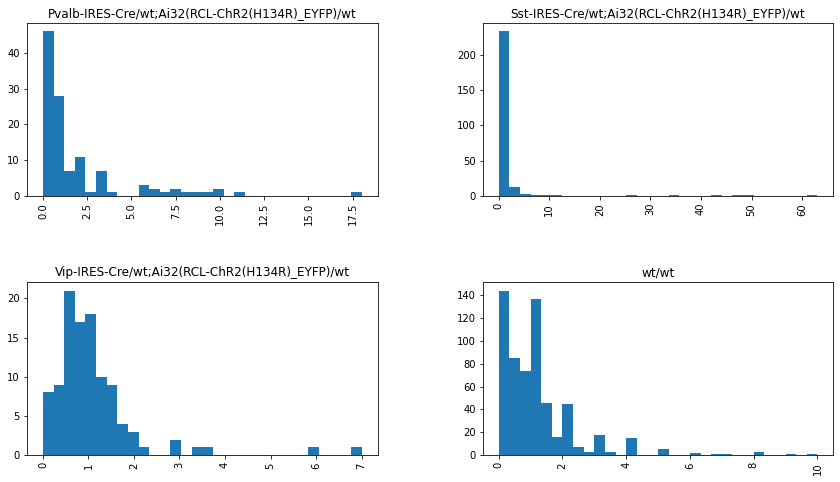

In [57]:
# drop inf ratios for now
all_units_df = all_units_df[~np.isinf(all_units_df['evoked_baseline_ratio'])]
all_units_df.dropna().hist('evoked_baseline_ratio', by='genotype', figsize=(14, 8), bins=30);

## compute response reliability

In [25]:
# load example results
fname = fr"G:\Shared drives\visual_encoding\data\results\pulse\0.01000000000021828s_3.csv"
df = pd.read_csv(fname)
df

,unit_id,ecephys_structure_acronym,genotype,trial_id,opto_baseline_rate,opto_evoked_rate
0,950929283,VISp,wt/wt,0,0.0,0.0
1,950929283,VISp,wt/wt,1,0.0,0.0
2,950929283,VISp,wt/wt,2,0.0,0.0
3,950929283,VISp,wt/wt,3,0.0,0.0
4,950929283,VISp,wt/wt,4,0.0,0.0
...,...,...,...,...,...,...
35116,951187369,VISp,wt/wt,20,125.0,0.0
35117,951187369,VISp,wt/wt,21,0.0,0.0
35118,951187369,VISp,wt/wt,22,0.0,125.0
35119,951187369,VISp,wt/wt,23,0.0,0.0


In [68]:
# compute response reliability for example unit
unit_ids = df['unit_id'].unique()
unit_id = unit_ids[-1]
unit_df = df[df['unit_id'] == unit_id]
unit_df['responded'] = unit_df['opto_evoked_rate'] > unit_df['opto_baseline_rate']
response_relability = unit_df['responded'].sum() / unit_df.shape[0]
print(response_relability)
unit_df

0.16


C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,unit_id,ecephys_structure_acronym,genotype,trial_id,opto_baseline_rate,opto_evoked_rate,responded
35096,951187369,VISp,wt/wt,0,0.0,125.0,True
35097,951187369,VISp,wt/wt,1,0.0,0.0,False
35098,951187369,VISp,wt/wt,2,0.0,0.0,False
35099,951187369,VISp,wt/wt,3,0.0,0.0,False
35100,951187369,VISp,wt/wt,4,0.0,0.0,False
35101,951187369,VISp,wt/wt,5,0.0,0.0,False
35102,951187369,VISp,wt/wt,6,0.0,0.0,False
35103,951187369,VISp,wt/wt,7,0.0,0.0,False
35104,951187369,VISp,wt/wt,8,125.0,125.0,False
35105,951187369,VISp,wt/wt,9,0.0,125.0,True


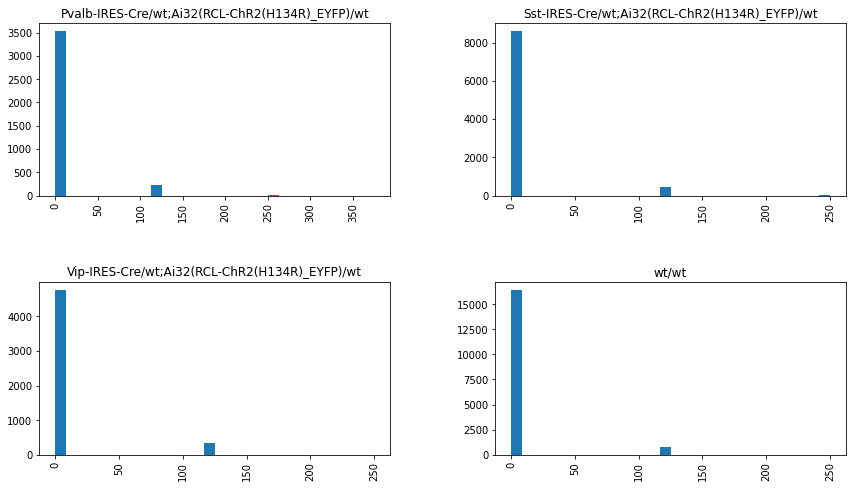

In [89]:
df.dropna().hist('opto_baseline_rate', by='genotype', figsize=(14, 8), bins=30);

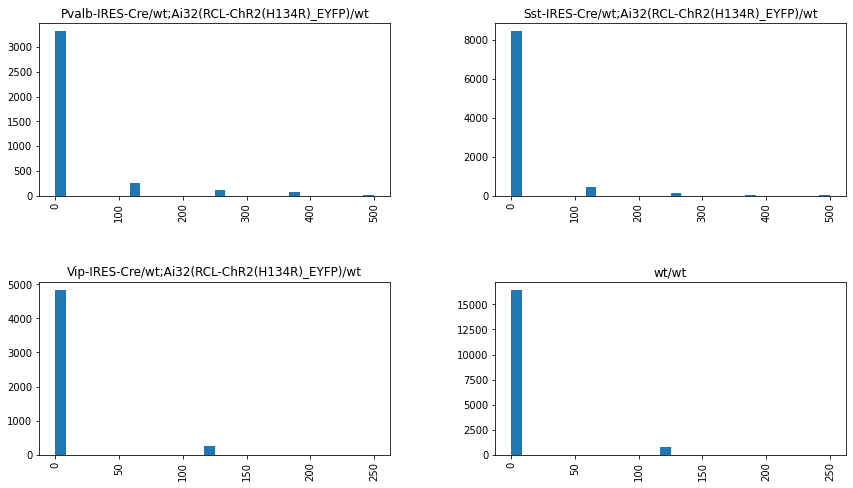

In [88]:
df.dropna().hist('opto_evoked_rate', by='genotype', figsize=(14, 8), bins=30);

In [69]:
def compute_response_reliability(df, unit_id):
        """
        Compute response reliability for a unit across all trials. Response reliability is 
        defined as the proportion of trials in which the unit responded to the stimulus.
        """
        
        unit_df = df[df['unit_id'] == unit_id]
        unit_df['responded'] = unit_df['opto_evoked_rate'] > unit_df['opto_baseline_rate']
        response_relability = unit_df['responded'].sum() / unit_df.shape[0]
        
        return response_relability

In [82]:
# compute response reliability for all units

# init
rr = df.groupby(['unit_id', 'ecephys_structure_acronym', 'genotype']).mean().drop(columns=['trial_id', 'opto_baseline_rate', 'opto_evoked_rate']).reset_index()
rr.assign(response_relability=np.nan)

# compute rr
for unit in rr['unit_id'].unique():
    rr.loc[rr['unit_id']==unit, 'response_relability'] = compute_response_reliability(df, unit)

rr

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,unit_id,ecephys_structure_acronym,genotype,response_relability
0,950922446,VISp,wt/wt,0.133333
1,950922495,VISp,wt/wt,0.000000
2,950922511,VISp,wt/wt,0.000000
3,950922546,VISp,wt/wt,0.000000
4,950922579,VISp,wt/wt,0.000000
...,...,...,...,...
1674,951187345,VISp,wt/wt,0.120000
1675,951187357,VISp,wt/wt,0.000000
1676,951187369,VISp,wt/wt,0.160000
1677,951187421,VISp,wt/wt,0.000000


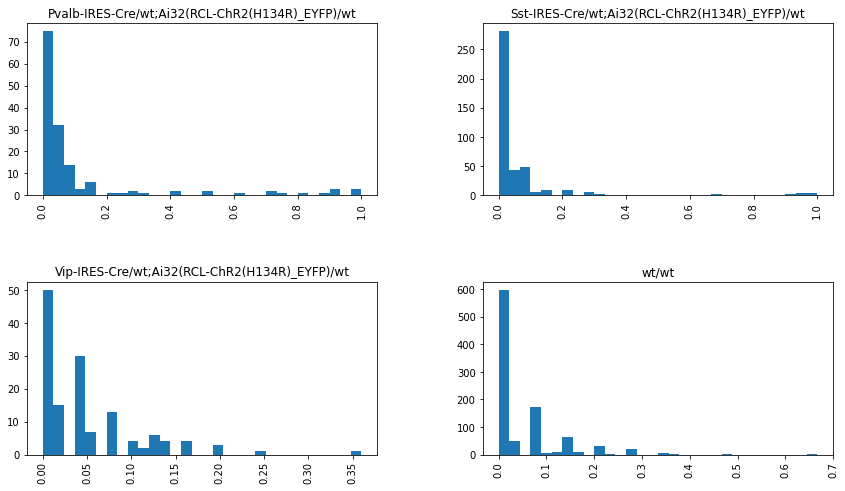

In [83]:
# plot results
rr.dropna().hist('response_relability', by='genotype', figsize=(14, 8), bins=30);